In [258]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Sentiment Analysis in Python

In this notebook we will be doing some sentiment analysis in python using two different techniquesL

1. VADER(Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model Form
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [260]:
# 文件的基本路径
base_path = '/Users/chenjianfeng/Desktop/5243/project 1 happy DB/HappyDB-master/happydb/data/'

# CSV文件名列表
csv_files = [
    'cleaned_hm.csv', 
    'demographic.csv', 
    'original_hm.csv', 
    'senselabel.csv', 
    'vad.csv'
]

# 使用字典推导式创建一个字典，其中键是文件名，值是对应的DataFrame
dataframes = {file: pd.read_csv(f"{base_path}{file}") for file in csv_files}

# 通过文件名访问每个DataFrame，并打印前几行
for file, dataframe in dataframes.items():
    print(f"Head rows of {file}:\n")
    display(dataframe.head())  # 修正变量名


Head rows of cleaned_hm.csv:



,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


Head rows of demographic.csv:



,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


Head rows of original_hm.csv:



,hmid,hm,reflection,wid
0,27673,I went on a successful date with someone I fel...,24h,2053
1,27674,I was happy when my son got 90% marks in his e...,24h,2
2,27675,I went to the gym this morning and did yoga.,24h,1936
3,27676,We had a serious talk with some friends of our...,24h,206
4,27677,I went with grandchildren to butterfly display...,24h,6227


Head rows of senselabel.csv:



,hmid,tokenOffset,word,lowercaseLemma,POS,MWE,offsetParent,supersenseLabel
0,31526,1,I,i,PRON,O,0,NaN
1,31526,2,found,find,VERB,O,0,v.cognition
2,31526,3,a,a,DET,O,0,NaN
3,31526,4,silver,silver,ADJ,O,0,NaN
4,31526,5,coin,coin,NOUN,O,0,n.artifact


Head rows of vad.csv:



,hmid,valency,dominance,arousal
0,31526,6.614000,5.840000,3.750000
1,37050,5.663158,5.461579,3.983947
2,46196,5.440000,5.364000,4.661500
3,50108,NaN,NaN,NaN
4,55093,6.195714,5.657143,4.118571


In [261]:
# 文件的基本路径
#base_path = '/kaggle/input/happy-db-data-set/happydb/data/topic_dict' 最后少了一个/
# 如果 base_path 的结尾没有斜杠，那么它会直接与 file 名称合并，会报错。
base_path = '/Users/chenjianfeng/Desktop/5243/project 1 happy DB/HappyDB-master/happydb/data/topic_dict/'


# CSV文件名列表
csv_files = [
    'entertainment-dict.csv', 
    'exercise-dict.csv', 
    'family-dict.csv', 
    'food-dict.csv', 
    'people-dict.csv',
    'pets-dict.csv',
    'school-dict.csv',
    'shopping-dict.csv',
    'work-dict.csv',    
]

# 使用字典推导式创建一个字典，其中键是文件名，值是对应的DataFrame
dataframes_2 = {file: pd.read_csv(f"{base_path}{file}") for file in csv_files}

# 通过文件名访问每个DataFrame，并打印前几行
for file, dataframe in dataframes_2.items():
    print(f"Head rows of {file}:\n", )
    display(dataframe.head(10))  # 使用IPython.display.display来呈现DataFrame

Head rows of entertainment-dict.csv:



,movie
0,tv
1,film
2,television
3,show
4,book
5,videogame
6,films
7,movies
8,shows
9,books


Head rows of exercise-dict.csv:



,10k
0,5k
1,abs
2,aerobic
3,aerobics
4,aikido
5,anaerobic
6,ashtanga
7,backpacking
8,badminton
9,barbell


Head rows of family-dict.csv:



,aunt
0,auntie
1,aunties
2,aunts
3,aunty
4,brother
5,brother-in-law
6,brothers
7,children
8,cousin
9,cousins


Head rows of food-dict.csv:



,Applebee's
0,Arby's
1,IHOP
2,Macdonalds
3,[\w]*bread
4,[\w]*cake
5,[\w]*tart
6,aioli
7,ales
8,almond
9,almonds


Head rows of people-dict.csv:



,aunt
0,auntie
1,aunties
2,aunts
3,aunty
4,babies
5,baby
6,bae
7,best friend
8,bestfriend
9,bestfriends


Head rows of pets-dict.csv:



,26mon
0,airedale
1,beagle
2,beagles
3,bichon
4,bird
5,birds
6,bulldog
7,bunnies
8,bunny
9,camels


Head rows of school-dict.csv:



,school
0,college
1,homework
2,home work
3,exam
4,math test
5,grade
6,final exam
7,A\+
8,exams
9,grades


Head rows of shopping-dict.csv:



,acquired
0,bargain
1,bargains
2,bought
3,buy
4,buying
5,cheap
6,cheaper
7,discount
8,discounted
9,discounts


Head rows of work-dict.csv:



,CEO
0,a raise
1,advertising
2,assistant
3,associate
4,boss
5,bosses
6,business
7,businesses
8,co-ordinator
9,co-worker


In [262]:
# Read the general data
df_cleaned_hm = pd.read_csv('/Users/chenjianfeng/Desktop/5243/project 1 happy DB/HappyDB-master/happydb/data/cleaned_hm.csv')
df_demographic = pd.read_csv('/Users/chenjianfeng/Desktop/5243/project 1 happy DB/HappyDB-master/happydb/data/demographic.csv')
df_original_hm = pd.read_csv('/Users/chenjianfeng/Desktop/5243/project 1 happy DB/HappyDB-master/happydb/data/original_hm.csv')
df_senselabel = pd.read_csv('/Users/chenjianfeng/Desktop/5243/project 1 happy DB/HappyDB-master/happydb/data/senselabel.csv')
df_vad = pd.read_csv('/Users/chenjianfeng/Desktop/5243/project 1 happy DB/HappyDB-master/happydb/data/vad.csv')

In [263]:
# Merge the cleaned_hm.csv and demographic.csv based on 'wid'
df_merged = pd.merge(df_cleaned_hm, df_demographic, on='wid', how='outer')

df_merged.head() # Display the first few rows of the merged dataframe

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood
0,27673.0,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1.0,NaN,affection,35,USA,m,single,n
1,27873.0,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1.0,NaN,leisure,35,USA,m,single,n
2,28073.0,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1.0,NaN,leisure,35,USA,m,single,n
3,33522.0,2053,24h,Went to see a movie with my friend,Went to see a movie with my friend,True,1.0,NaN,bonding,35,USA,m,single,n
4,34522.0,2053,24h,"Played guitar, learning a song on it","Played guitar, learning a song on it",True,1.0,NaN,leisure,35,USA,m,single,n


In [264]:
type(df_merged['reflection_period'])

pandas.core.series.Series

In [265]:
df_merged['reflection_period']

0         24h
1         24h
2         24h
3         24h
4         24h
         ... 
100533    24h
100534    24h
100535    NaN
100536    NaN
100537    NaN
Name: reflection_period, Length: 100538, dtype: object

In [266]:
# 使用value_counts()方法来计算worker refelction time中 24h 和 3m 的比例
value_counts = df_merged['reflection_period'].value_counts()

# 打印结果
print(value_counts)

3m     50704
24h    49831
Name: reflection_period, dtype: int64


In [267]:
# 使用value_counts()方法来计算marital中 marrige 和  single 的比例
value_counts = df_merged['marital'].value_counts()

# 打印结果
print(value_counts)

single       54107
married      41344
divorced      3803
separated      649
widowed        477
Name: marital, dtype: int64


In [268]:
# 使用value_counts()方法来计算parenthood中 n 和  y 的比例
value_counts = df_merged['parenthood'].value_counts()

# 打印结果
print(value_counts)

n    60938
y    39521
Name: parenthood, dtype: int64


In [269]:
# 使用value_counts()方法来计算gender中 female 和  male 的比例
value_counts = df_merged['gender'].value_counts()

# 打印结果
print(value_counts)

m    57692
f    42069
o      697
Name: gender, dtype: int64


In [270]:
df_merged

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood
0,27673.0,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1.0,NaN,affection,35,USA,m,single,n
1,27873.0,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1.0,NaN,leisure,35,USA,m,single,n
2,28073.0,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1.0,NaN,leisure,35,USA,m,single,n
3,33522.0,2053,24h,Went to see a movie with my friend,Went to see a movie with my friend,True,1.0,NaN,bonding,35,USA,m,single,n
4,34522.0,2053,24h,"Played guitar, learning a song on it","Played guitar, learning a song on it",True,1.0,NaN,leisure,35,USA,m,single,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100533,128259.0,11050,24h,Yesterday evening I received a call from unkno...,Yesterday evening I received a call from unkno...,True,7.0,bonding,bonding,65,IND,m,married,y
100534,128759.0,11050,24h,I am fond of seeing cricket match. Yesterday t...,I am fond of seeing cricket match. Yesterday t...,True,6.0,NaN,enjoy_the_moment,65,IND,m,married,y
100535,NaN,292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,IND,m,single,y
100536,NaN,9328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,USA,m,married,n


In [271]:
print(df_merged.shape)

(100538, 14)


In [272]:
df = df_merged.head(500)
df

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood
0,27673.0,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1.0,NaN,affection,35,USA,m,single,n
1,27873.0,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1.0,NaN,leisure,35,USA,m,single,n
2,28073.0,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1.0,NaN,leisure,35,USA,m,single,n
3,33522.0,2053,24h,Went to see a movie with my friend,Went to see a movie with my friend,True,1.0,NaN,bonding,35,USA,m,single,n
4,34522.0,2053,24h,"Played guitar, learning a song on it","Played guitar, learning a song on it",True,1.0,NaN,leisure,35,USA,m,single,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,80220.0,21,3m,A happiest moment in past three months was i g...,A happiest moment in past three months was i g...,True,1.0,NaN,achievement,29.0,IND,m,single,y
496,81220.0,21,3m,A good profit from last month made me feel awe...,A good profit from last month made me feel awe...,True,1.0,NaN,achievement,29.0,IND,m,single,y
497,82220.0,21,3m,a new car bought by my dad give me honor in th...,a new car bought by my dad give me honor in th...,True,1.0,NaN,achievement,29.0,IND,m,single,y
498,83172.0,21,3m,A long prayer in mosque make feel happy and it...,A long prayer in mosque make feel happy and it...,True,1.0,NaN,enjoy_the_moment,29.0,IND,m,single,y


In [273]:
print(df.shape)

(500, 14)


# Quick EDA

In [274]:
df = df_cleaned_hm
df['hmid'].value_counts()

27673     1
95062     1
95060     1
95059     1
95058     1
         ..
61367     1
61366     1
61365     1
61364     1
128766    1
Name: hmid, Length: 100535, dtype: int64

In [275]:
df['hmid'].value_counts().sort_index()

27673     1
27674     1
27675     1
27676     1
27677     1
         ..
128762    1
128763    1
128764    1
128765    1
128766    1
Name: hmid, Length: 100535, dtype: int64

In [276]:
# df['hmid'].value_counts().sort_index().plot(kind='bar', title='Counts of happy moment by id', figsize=(10,5))


# Baisc NLTK 

In [277]:
import nltk
example = df['cleaned_hm'][0]
print(example)


I went on a successful date with someone I felt sympathy and connection with.


In [278]:
nltk.download('punkt')
tokens = nltk.word_tokenize(example) #


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chenjianfeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [279]:
tokens[:10]

['I', 'went', 'on', 'a', 'successful', 'date', 'with', 'someone', 'I', 'felt']

In [280]:
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(tokens) #词性判断

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chenjianfeng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('I', 'PRP'),
 ('went', 'VBD'),
 ('on', 'IN'),
 ('a', 'DT'),
 ('successful', 'JJ'),
 ('date', 'NN'),
 ('with', 'IN'),
 ('someone', 'NN'),
 ('I', 'PRP'),
 ('felt', 'VBD'),
 ('sympathy', 'JJ'),
 ('and', 'CC'),
 ('connection', 'NN'),
 ('with', 'IN'),
 ('.', '.')]

In [281]:
tagged_tokens = nltk.pos_tag(tokens) #词性判断
tagged_tokens[:10]

[('I', 'PRP'),
 ('went', 'VBD'),
 ('on', 'IN'),
 ('a', 'DT'),
 ('successful', 'JJ'),
 ('date', 'NN'),
 ('with', 'IN'),
 ('someone', 'NN'),
 ('I', 'PRP'),
 ('felt', 'VBD')]

In [282]:
# Chunk & Chunk.ne_chunk
#help(nltk.chunk)
help(nltk.chunk.ne_chunk)

Help on function ne_chunk in module nltk.chunk:

ne_chunk(tagged_tokens, binary=False)
    Use NLTK's currently recommended named entity chunker to
    chunk the given list of tagged tokens.



In [283]:
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged_tokens)
entities.pprint()

(S
  I/PRP
  went/VBD
  on/IN
  a/DT
  successful/JJ
  date/NN
  with/IN
  someone/NN
  I/PRP
  felt/VBD
  sympathy/JJ
  and/CC
  connection/NN
  with/IN
  ./.)


[nltk_data] Downloading package words to
[nltk_data]     /Users/chenjianfeng/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Step 1. VADER sentiment analysis

 ##### we will use NLTK's ``` SentimentIntensityAnalyzer``` to get the neg/nuue/pos scores of the text. 
   - This uses a 'big-of-words' approach
     1. Stop words are removed
     2. Each word is scored and combined to a total score
 
 

In [284]:
!pip install --upgrade nltk

In [285]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chenjianfeng/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [286]:
!pip install --upgrade tqdm

In [287]:
# from nltk.sentiment import SentimentIntensityAnalyzer
# from tqdm.notebook import tqdm

# sia = SentimentIntensityAnalyzer()

#报错可能是由于您的NLTK版本问题导致的，NLTK的最新版本中不再支持 nltk.sentiment 模块。如果您使用的是较新的NLTK版本，您应该使用nltk.sentiment.vader来进行情感分析，而不是nltk.sentiment模块。

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()



In [288]:
# 综合情感得分 neg：中性 neu：消极 pos：积极 compound：综合 = aggrigation of neg, neu and pos
sia.polarity_scores('I went on a successful date with someone I felt sympathy and connection with.')

{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.743}

In [289]:
type(df_merged['cleaned_hm'])


pandas.core.series.Series

In [290]:
# the data type in series of 'cleaned_hm' is not all 'str' 
are_all_strings = df['cleaned_hm'].apply(lambda x: isinstance(x, str)).all()

print(are_all_strings)

True


In [291]:
df = df_merged
df

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood
0,27673.0,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1.0,NaN,affection,35,USA,m,single,n
1,27873.0,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1.0,NaN,leisure,35,USA,m,single,n
2,28073.0,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1.0,NaN,leisure,35,USA,m,single,n
3,33522.0,2053,24h,Went to see a movie with my friend,Went to see a movie with my friend,True,1.0,NaN,bonding,35,USA,m,single,n
4,34522.0,2053,24h,"Played guitar, learning a song on it","Played guitar, learning a song on it",True,1.0,NaN,leisure,35,USA,m,single,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100533,128259.0,11050,24h,Yesterday evening I received a call from unkno...,Yesterday evening I received a call from unkno...,True,7.0,bonding,bonding,65,IND,m,married,y
100534,128759.0,11050,24h,I am fond of seeing cricket match. Yesterday t...,I am fond of seeing cricket match. Yesterday t...,True,6.0,NaN,enjoy_the_moment,65,IND,m,married,y
100535,NaN,292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,IND,m,single,y
100536,NaN,9328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,USA,m,married,n


In [292]:
# 确保已下载VADER的词典
nltk.download('vader_lexicon')

# 初始化VADER的SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# 为了简化展示，这里只打印前100个句子的情感分析结果
for sentence in df['cleaned_hm'].head(1):
    scores = sia.polarity_scores(sentence)
    print(f"句子：{sentence}")
    print(f"情感得分：{scores}\n")


句子：I went on a successful date with someone I felt sympathy and connection with.
情感得分：{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.743}



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chenjianfeng/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [293]:
# Run the polarity score on the entire dataset 遍历整个数据集

sia = SentimentIntensityAnalyzer() # make sure the sia has been initialized

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['cleaned_hm']) #确保数据都是str，不会出现其他dtype
    myid = row['hmid']
    res[myid] = sia.polarity_scores(text)  
    # Remove this break if you want to iterate through the entire DataFrame
    # break 

  0%|          | 0/100538 [00:00<?, ?it/s]

In [294]:
# # 查看res字典的前5个 key value pairs
# count = 0
# for key in res:
#     print(f"{key}: {res[key]}")
#     count += 1
#     if count == 5:
#         break
res

{27673.0: {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.743},
 27873.0: {'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'compound': 0.836},
 28073.0: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 33522.0: {'neg': 0.0, 'neu': 0.652, 'pos': 0.348, 'compound': 0.4939},
 34522.0: {'neg': 0.0, 'neu': 0.676, 'pos': 0.324, 'compound': 0.34},
 35522.0: {'neg': 0.0, 'neu': 0.38, 'pos': 0.62, 'compound': 0.5994},
 40281.0: {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.34},
 40381.0: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 40481.0: {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.4019},
 27674.0: {'neg': 0.0, 'neu': 0.73, 'pos': 0.27, 'compound': 0.5719},
 27874.0: {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.8955},
 28074.0: {'neg': 0.0, 'neu': 0.6, 'pos': 0.4, 'compound': 0.7184},
 29946.0: {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'compound': 0.4588},
 30945.0: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 31944.0: {'neg': 0.0, 'neu

In [295]:
df_res = pd.DataFrame(res)
df_res

,27673.0,27873.0,28073.0,33522.0,34522.0,35522.0,40281.0,40381.0,40481.0,27674.0,...,128748.0,127751.0,128251.0,128751.0,127759.0,128259.0,128759.0,NaN,NaN,NaN
neg,0.000,0.000,0.0,0.0000,0.000,0.0000,0.000,0.0,0.0000,0.0000,...,0.0000,0.0,0.0000,0.0,0.0230,0.0000,0.0540,0.0,0.0,0.0
neu,0.588,0.553,1.0,0.6520,0.676,0.3800,0.714,1.0,0.7690,0.7300,...,0.7190,1.0,0.6310,1.0,0.6020,0.8220,0.7000,1.0,1.0,1.0
pos,0.412,0.447,0.0,0.3480,0.324,0.6200,0.286,0.0,0.2310,0.2700,...,0.2810,0.0,0.3690,0.0,0.3750,0.1780,0.2460,0.0,0.0,0.0
compound,0.743,0.836,0.0,0.4939,0.340,0.5994,0.340,0.0,0.4019,0.5719,...,0.5994,0.0,0.6249,0.0,0.9801,0.9081,0.8986,0.0,0.0,0.0


In [296]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
27673.0,0.000,0.588,0.412,0.7430
27873.0,0.000,0.553,0.447,0.8360
28073.0,0.000,1.000,0.000,0.0000
33522.0,0.000,0.652,0.348,0.4939
34522.0,0.000,0.676,0.324,0.3400
...,...,...,...,...
128259.0,0.000,0.822,0.178,0.9081
128759.0,0.054,0.700,0.246,0.8986
NaN,0.000,1.000,0.000,0.0000
NaN,0.000,1.000,0.000,0.0000


In [297]:
df = pd.DataFrame(vaders)
df.reset_index(inplace=True)
df.rename(columns={'index': 'hmid'}, inplace=True)
df

,hmid,neg,neu,pos,compound
0,27673.0,0.000,0.588,0.412,0.7430
1,27873.0,0.000,0.553,0.447,0.8360
2,28073.0,0.000,1.000,0.000,0.0000
3,33522.0,0.000,0.652,0.348,0.4939
4,34522.0,0.000,0.676,0.324,0.3400
...,...,...,...,...,...
100533,128259.0,0.000,0.822,0.178,0.9081
100534,128759.0,0.054,0.700,0.246,0.8986
100535,NaN,0.000,1.000,0.000,0.0000
100536,NaN,0.000,1.000,0.000,0.0000


In [298]:
# 成功合并cleaned_hm和res，目前每一条text后面都有neg, neu, pos, compound的情感得分
vaders = vaders.merge(df_cleaned_hm, how='left') 
vaders

,hmid,neg,neu,pos,compound,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673.0,0.000,0.588,0.412,0.7430,2053.0,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1.0,NaN,affection
1,27873.0,0.000,0.553,0.447,0.8360,2053.0,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1.0,NaN,leisure
2,28073.0,0.000,1.000,0.000,0.0000,2053.0,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1.0,NaN,leisure
3,33522.0,0.000,0.652,0.348,0.4939,2053.0,24h,Went to see a movie with my friend,Went to see a movie with my friend,True,1.0,NaN,bonding
4,34522.0,0.000,0.676,0.324,0.3400,2053.0,24h,"Played guitar, learning a song on it","Played guitar, learning a song on it",True,1.0,NaN,leisure
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100533,128259.0,0.000,0.822,0.178,0.9081,11050.0,24h,Yesterday evening I received a call from unkno...,Yesterday evening I received a call from unkno...,True,7.0,bonding,bonding
100534,128759.0,0.054,0.700,0.246,0.8986,11050.0,24h,I am fond of seeing cricket match. Yesterday t...,I am fond of seeing cricket match. Yesterday t...,True,6.0,NaN,enjoy_the_moment
100535,NaN,0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100536,NaN,0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plot VADER result

In [303]:
pip install --upgrade matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/ce/25/a557ee10ac9dce1300850024707ce1850a6958f1673a9194be878b99d631/matplotlib-3.8.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 12.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
Note: you may need to restart the kernel to use updated packages.


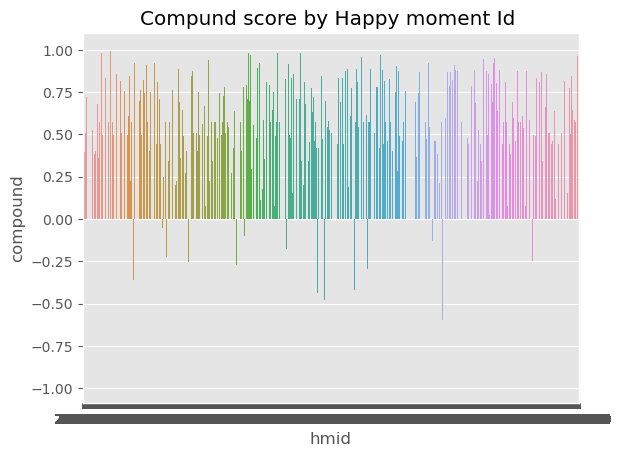

In [304]:
import matplotlib.pyplot as plt
ax = sns.barplot(data=vaders, x='hmid', y='compound')
ax.set_title('Compound score by Happy moment Id ')
plt.show()

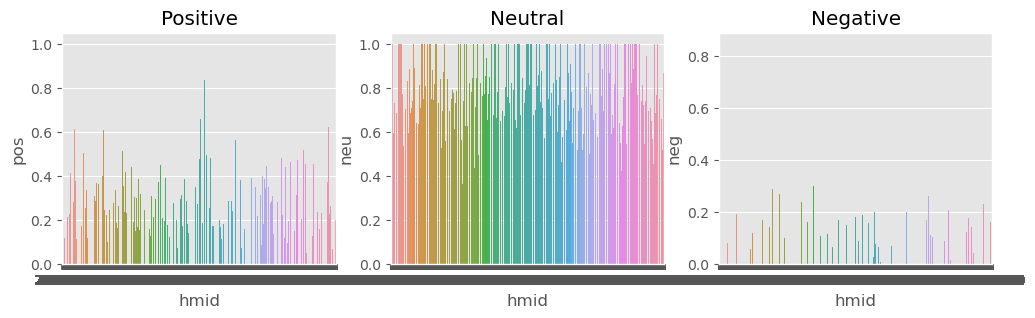

In [307]:
# fig, axs = plt.subplot(1, 3, figsize = (12,3)) 如果是同时出图就是subplots而不是subplot，这里注意细节
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='hmid', y='pos', ax = axs[0])
sns.barplot(data=vaders, x='hmid', y='neu', ax = axs[1])
sns.barplot(data=vaders, x='hmid', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()